# CASA Summary
The pipeline used for calibration and flagging closely follows that of the CASA pipeline (https://casaguides.nrao.edu/index.php?title=VLA-S-CASA_Pipeline-CASA6.2.1#Stage_7._hifv_checkflag:_Flag_possible_RFI_on_BP_calibrator_using_rflag). This notebook summarises the output of the pipeline (calibration tables, flagging summaries, data plots) and can be used to get an overview of the data and identify bad data that needs to be flagged manually.

In [1]:
import os
import sys
import h5py
import yaml
import casatasks
import numpy as np
from astropy.time import Time
import astropy.units as u
from ipywidgets import interact

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.viridis  
cmap.set_bad(color='red')

from IPython.display import Image

# read yaml file
with open("../input/config.yaml", "r") as file:
    conf = yaml.safe_load(file)
    
sys.path.append(os.path.join(os.curdir, "../"))

from vlapy import vladata, inspect

## Obervation Information 
The data below is the output of CASA's listobs task and can be used to fill in the yaml file "obs.yaml", which contains all the parameters for the pipeline.

In [2]:
obs = conf["obs list"][0]
root = os.path.join(conf["root"], f"{obs}")
name = obs.split(".")[0]

ms = os.path.join(root, f"{obs}_hanning.ms")
vladata.listobs(ms)

BeginTime
58744.51180555556 

EndTime
58744.537152777775 

IntegrationTime
2190.0 

field_0
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 1.4948845339}, 'm1': {'unit': 'rad', 'value': 0.8700817014000001}, 'refer': 'J2000', 'type': 'direction'}
name :  J0542+4951


field_1
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.7622531831}, 'm1': {'unit': 'rad', 'value': 0.7202694229000001}, 'refer': 'J2000', 'type': 'direction'}
name :  J1033+4116


field_2
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.8307109711}, 'm1': {'unit': 'rad', 'value': 0.8137042526}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J1048+4637


field_3
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 3.0145677806}, 'm1': {'unit': 'rad', 'value': 0.6676783576000002}, 'refer': 'J2000', 'type': 'direction'}
name :  J1130+3815


field_4
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 3.0425255836}, 'm1': {'unit': 'rad', 'value': 0.6253943770000001}, 'refer': 'J20

### Array Layout

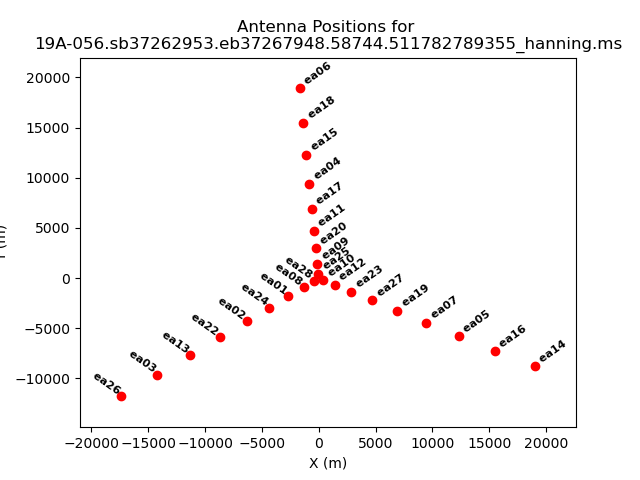

In [3]:
Image(filename=root + "/plots/obsplots/antlayout.png")

### Plot Elevation vs. Time
Observations low in elevation might see more RFI. The plot is colorised by field. Each target field is in between two phase calibrators.

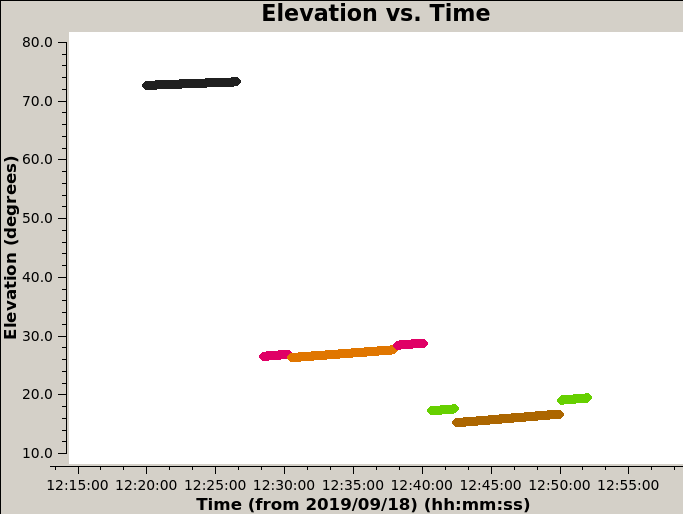

In [4]:
Image(filename=root + "/plots/obsplots/elevation_vs_time.png")

## VLA Deterministic Flags and Manual Flags
These include antennas not on source, shadowed antennas, scans with non-relevant intents, autocorrelations, edge channels of spectral windows, edge channels of the baseband, clipping absolute zero values produced by the correlator and the first few integrations of a scan (quacking). Manual flags are also applied for data known to be bad (RFI, obs reports). Below is a summary of the flags before and after applying the deterministic flags. Use the flagging frequency to find a suitable reference antenna and specify it in the yaml file.

In [5]:
summary_before = np.load(root + "/output/detflag_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/detflag_summary_after.npy", allow_pickle='TRUE').item()

# print flagging summary
def print_summary(item):
    for subitem in summary_before[item]:
        print(f"{item} {subitem}")
        print(
            "Before: {:.4f}, After: {:.4f}".format(
                100.0 * summary_before[item][subitem]["flagged"] / summary_before[item][subitem]["total"],
                100.0 * summary_after[item][subitem]["flagged"] / summary_after[item][subitem]["total"],
            )
        )
        print("")
        
print("Flag occupancy (percent) before and after deterministic flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after deterministic flags:

field J0542+4951
Before: 22.6119, After: 40.0270

field J1033+4116
Before: 39.4121, After: 53.0980

field J1130+3815
Before: 17.1148, After: 35.7814

field QSO J1048+4637
Before: 5.6538, After: 26.8853

field QSO J1137+3549
Before: 4.7783, After: 26.1940

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 13.5074, After: 32.9713

scan 3
Before: 54.9723, After: 65.2169

scan 4
Before: 5.6538, After: 26.8853

scan 5
Before: 12.1253, After: 31.8459

scan 6
Before: 25.3254, After: 42.1615

scan 7
Before: 4.7783, After: 26.1940

scan 8
Before: 7.8778, After: 28.6038

antenna ea01
Before: 16.6574, After: 29.5680

antenna ea02
Before: 16.8296, After: 29.7134

antenna ea03
Before: 17.0199, After: 29.8608

antenna ea04
Before: 16.8531, After: 29.7272

antenna ea05
Before: 16.9790, After: 29.8300

antenna ea06
Before: 17.0414, After: 29.8810

antenna ea07
Before: 17.1429, After: 29.9643

antenna ea08
Before: 17.1574, After: 29

### Plot Online Flags
Plot flaggingreason vs. time. This shows which antennas are flagged due to focus errors, subreflector errors and antenna not on source. This plot can help identify suitable reference antennas.

In [6]:
if os.path.exists(root+"/plots/dataplots/flaggingreason_vs_time.png"):
    Image(filename=root+"/plots/dataplots/flaggingreason_vs_time.png")

### Plot Antenna Data Stream
If an antenna has missing data, it should not be used as a reference.

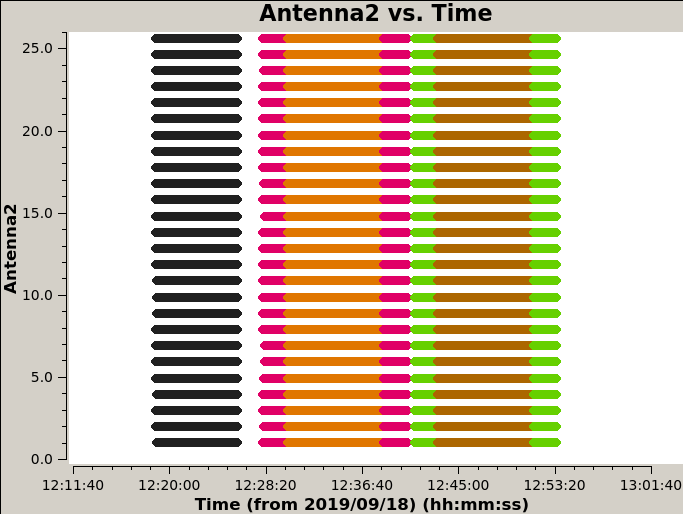

In [7]:
Image(filename=root + "/plots/obsplots/data_stream.png")

## Find Dead Antennas
Antennas that have low power should be flagged. This is also a good time to check for suitable reference antennas.

In [8]:
def plot_dead_ants(ant):
    plotfile = root + f"/plots/dataplots/find_dead_ants_amp_vs_freq_ant_{ant}.png"
    img = mpimg.imread(plotfile)
    plt.imshow(img)
    
interact(plot_dead_ants, ant=(1, 26))
    

interactive(children=(IntSlider(value=13, description='ant', max=26, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_dead_ants(ant)>

## RFI Inspection
The visibility amplitudes are first averaged across baselines and polarisation products. A modified Z-score is then computed across time as $Z_i = \frac{x_i - \mathrm{med}\{x_i\}_i}{\sigma_\mathrm{MAD}}$, 

where $\sigma_\mathrm{MAD} = \mathrm{med}\{\left|x_i - \mathrm{med}\{x_i\}_i\right|\}$ is the Median Absolute Deviation (MAD), and $x_i$ is the data (visibility amplitude) of the $i^\mathrm{th}$ integration.

The resulting Z-score is a spectrogram with dimensions of time and frequency. It can further be averaged across one of these dimensions to obtain a time series or a spectrum, which are useful for identifying broadband and persistent narrowband RFI respectively.

Use this to identify one clean channel per spectral window which will be used for the initial gain calibration.

#### Load Data

In [9]:

with h5py.File(root + f"/output/z_score_data.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

#### Plot

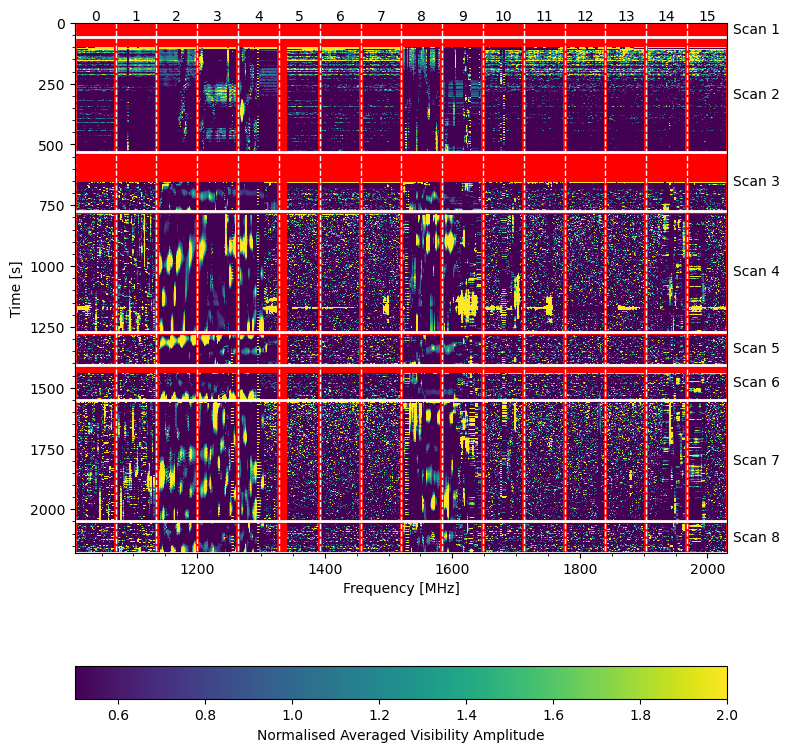

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=0.5, vmax=2, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", label="Normalised Averaged Visibility Amplitude")
plt.tight_layout()
plt.show()

In [11]:
def plot_wf_spw(i):
    inspect.plot_wf_spw(freq_array, z_score, i, 2, ntimes, plot_masked=True)
    
interact(plot_wf_spw, i=(0, 15))

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf_spw(i)>

In [12]:
summary_before = np.load(root + "/output/manual_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/manual_flags_summary_after.npy", allow_pickle='TRUE').item()
        
print("Flag occupancy (percent) before and after manual flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after manual flags:

field J0542+4951
Before: 68.9800, After: 68.9800

field J1033+4116
Before: 78.2860, After: 78.2860

field J1130+3815
Before: 69.9532, After: 69.9532

field QSO J1048+4637
Before: 63.5598, After: 63.5598

field QSO J1137+3549
Before: 62.1282, After: 62.1282

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 65.3306, After: 65.3306

scan 3
Before: 85.7120, After: 85.7120

scan 4
Before: 63.5598, After: 63.5598

scan 5
Before: 65.2636, After: 65.2636

scan 6
Before: 73.8053, After: 73.8053

scan 7
Before: 62.1282, After: 62.1282

scan 8
Before: 65.6195, After: 65.6195

antenna ea01
Before: 63.8924, After: 63.8924

antenna ea02
Before: 63.8924, After: 63.8924

antenna ea03
Before: 63.8924, After: 63.8924

antenna ea04
Before: 63.8924, After: 63.8924

antenna ea05
Before: 63.8924, After: 63.8924

antenna ea06
Before: 63.8924, After: 63.8924

antenna ea07
Before: 63.8924, After: 63.8924

antenna ea08
Before: 63.8924, After: 63.8

## Flux Calibrator Model
Print model flux densities and plot model amplitude vs. uv-distance. If the calibrator is not resolved, its amplitude should be constant across different uv-distances. If it is slightly resolved, the amplitude will decrease as a function of uv-distance.

In [13]:
setjy = np.load(root + "/output/setjy.npy", allow_pickle='TRUE').item()

print("model flux densities in Jy\n")

for spw in range(16):
    print("SPW {:2d}: I: {:.2f}, U: {:.2f}, V: {:.2f}, Q: {:.2f}".format(spw, *setjy["0"][str(spw)]["fluxd"]))

model flux densities in Jy

SPW  0: I: 28.13, U: 0.00, V: 0.00, Q: 0.00
SPW  1: I: 26.94, U: 0.00, V: 0.00, Q: 0.00
SPW  2: I: 25.85, U: 0.00, V: 0.00, Q: 0.00
SPW  3: I: 24.85, U: 0.00, V: 0.00, Q: 0.00
SPW  4: I: 23.92, U: 0.00, V: 0.00, Q: 0.00
SPW  5: I: 23.06, U: 0.00, V: 0.00, Q: 0.00
SPW  6: I: 22.27, U: 0.00, V: 0.00, Q: 0.00
SPW  7: I: 21.52, U: 0.00, V: 0.00, Q: 0.00
SPW  8: I: 20.83, U: 0.00, V: 0.00, Q: 0.00
SPW  9: I: 20.18, U: 0.00, V: 0.00, Q: 0.00
SPW 10: I: 19.57, U: 0.00, V: 0.00, Q: 0.00
SPW 11: I: 19.00, U: 0.00, V: 0.00, Q: 0.00
SPW 12: I: 18.46, U: 0.00, V: 0.00, Q: 0.00
SPW 13: I: 17.95, U: 0.00, V: 0.00, Q: 0.00
SPW 14: I: 17.47, U: 0.00, V: 0.00, Q: 0.00
SPW 15: I: 17.02, U: 0.00, V: 0.00, Q: 0.00


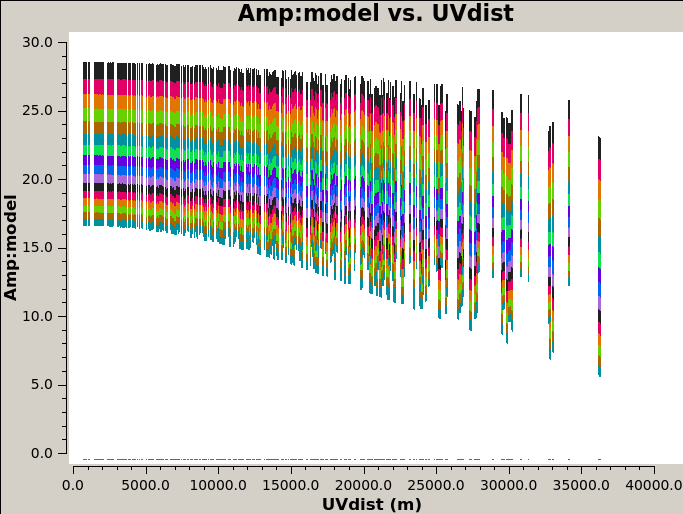

In [14]:
Image(filename=root + "/plots/calplots/setjy_model_amp_vs_uvdist.png")

## Prior Calibration

The prior calibration includes atmospheric opacity corrections, antenna offset corrections and requantizer (rq) gains. These are independent of calibrator observations and use external data instead.

### Weather
Plot weather data and print opacities. For frequencies below 10 GHz the opacity is negligibly small.  

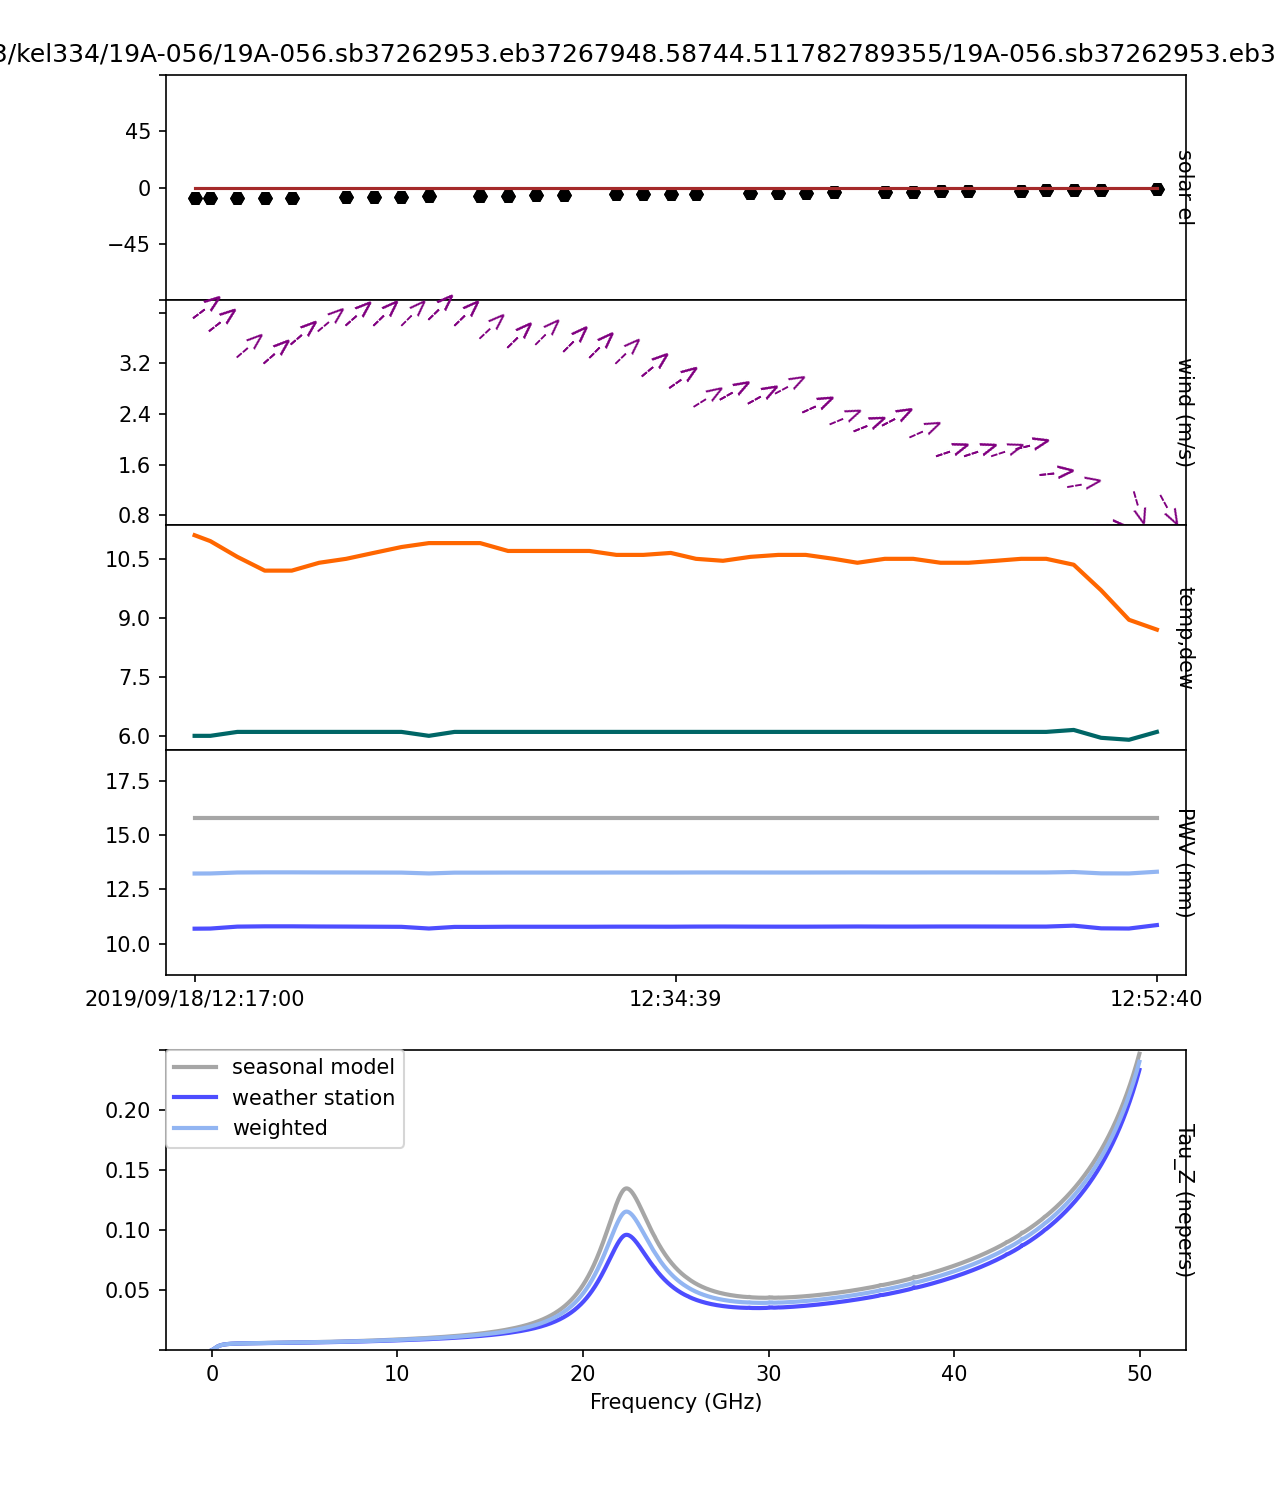

In [15]:
Image(filename=root + "/plots/calplots/weather.png")

In [16]:
opacities = np.load(root + "/output/weather.npy")

print("Opacities [Nepers]\n")

for spw, opacity in enumerate(opacities):
    print(f"SPW {spw}: {opacity}")

Opacities [Nepers]

SPW 0: 0.005156145504670995
SPW 1: 0.00521604230001692
SPW 2: 0.005268136303951705
SPW 3: 0.005313652182663858
SPW 4: 0.005354030156365918
SPW 5: 0.0053898666424734
SPW 6: 0.005422094745459627
SPW 7: 0.005451188753034495
SPW 8: 0.005477678822838807
SPW 9: 0.005501972286118477
SPW 10: 0.00552435923269206
SPW 11: 0.005545187791168971
SPW 12: 0.005564605491689138
SPW 13: 0.005582893355940872
SPW 14: 0.0056001610765702104
SPW 15: 0.0056165880715353745


## Plot Calibration Channels
These are the channels that have been selected for the gain calibration. They should be clean and should not exhibit any amplitude jumps.

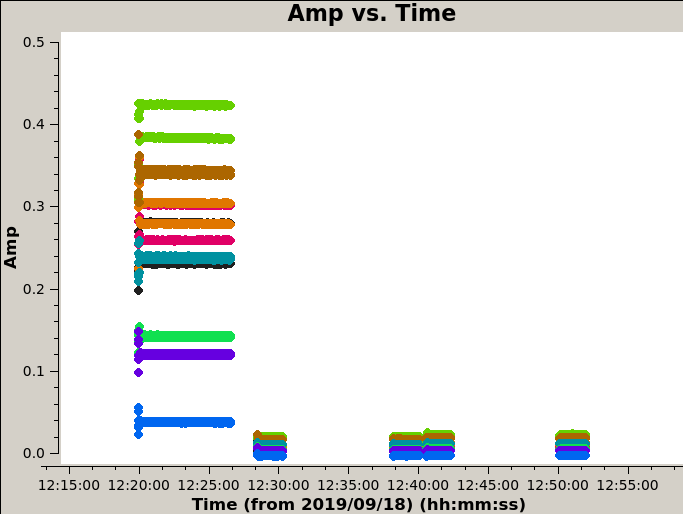

In [17]:
Image(filename=root + "/plots/dataplots/single_chans_amp_vs_time.png")

## Initial Calibration
The initial calibration is done to enable subsequent flagging with automated flagging routines such as CASA's RFlag. The calibration consists of an initial gain phase calibration, a delay calibration, an initial gain phase and amplitude calibration and a bandpass calibration. The two gain calibrations are used for the delay and bandpass calibrations, but are not applied to the data. The gain calibrations are done with a single channel per spectral window.

In [18]:
def plot_two_cols(im1, im2):
    """ 
    Plot two image side by side. E.g phase and amplitude.
    """
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))

    if os.path.exists(im1):
        img_1 = mpimg.imread(im1)
        ax[0].imshow(img_1)

    if os.path.exists(im2):
        img_2 = mpimg.imread(im2)
        ax[1].imshow(img_2)

### Specify Gain Tables

In [19]:
# specify calibration table names
rnd = 0
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table_0 = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration
This is an initial per-integration phase calibration and is done to avoid decorrelation under temporal averaging in the subsequent delay calibration. The gain phase should be stable in time. Antennas or spectral windows that have gain phase discontinuities should be flagged. If all but the reference antenna exhibit phase jumps, a difference reference antenna should be chosen.

In [20]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration
The delay calibration is done by fitting for the phase slopes across frequency with respect to the reference antenna. The first and last 15 channels of the spectral windows are not used in this step, since they have lower gains. The delays should lie between -5 and 5 ns, and anything outside that range should be treated with suspicion.

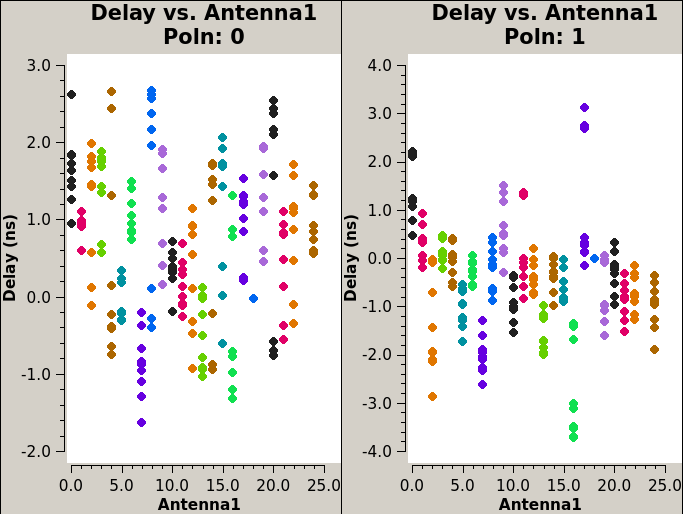

In [21]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration
Similarly to above, we perform an initial gain calibration for the bandpass calibration, but this time we also solve for the amplitudes. The phases and amplitudes should be constant with time and discontinuous solutions should be flagged.

In [22]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table_0}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table_0}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration
The amplitudes and phases of the bandpass calibration should be close to 1 and zero respectively after the initial gain calibration. Discontinuities should be flagged.

In [23]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [24]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

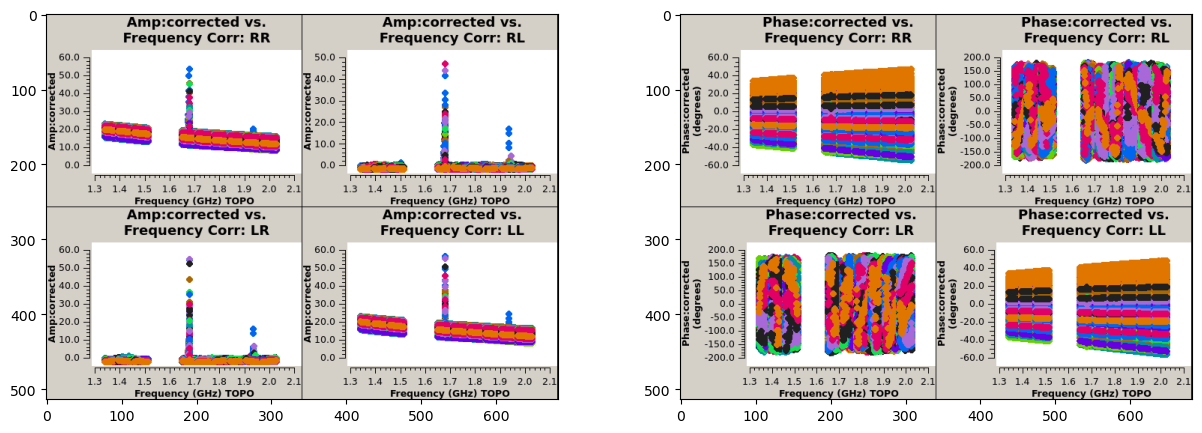

In [25]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_initcal_round_0_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

#### Plot Averaged Corrected Data
Iterate through spectral windows to identify RFI and flag bad channels manually below.

In [26]:
def plot_corrected_spw(spw):
    img = mpimg.imread(root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_avg_spw_{spw}_CorrRR,RL,LR,LL.png")
    plt.imshow(img)

interact(plot_corrected_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_corrected_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [27]:
rnd=0
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 0:

field J0542+4951
Before: 40.7673, After: 68.9800

antenna ea01
Before: 35.3554, After: 65.0810

antenna ea02
Before: 35.3759, After: 65.0810

antenna ea03
Before: 35.3642, After: 65.0810

antenna ea04
Before: 35.3788, After: 65.0810

antenna ea05
Before: 35.3554, After: 65.0810

antenna ea06
Before: 35.3759, After: 65.0810

antenna ea07
Before: 35.3642, After: 65.0810

antenna ea08
Before: 35.3788, After: 65.0810

antenna ea09
Before: 35.3554, After: 65.0810

antenna ea10
Before: 35.3759, After: 65.0810

antenna ea11
Before: 35.3642, After: 65.0810

antenna ea12
Before: 35.3788, After: 65.0810

antenna ea13
Before: 35.3554, After: 65.0810

antenna ea14
Before: 35.3759, After: 65.0810

antenna ea15
Before: 35.3642, After: 65.0810

antenna ea16
Before: 35.3788, After: 65.0810

antenna ea17
Before: 35.3554, After: 65.0810

antenna ea18
Before: 35.6339, After: 65.3390

antenna ea19
Before: 35.3642, After: 65.0810

ante

## First Round of Flagging on Primary Calibrator
The first round of flagging is performed on the primary calibrator only. The flagging routine runs RFlag with timedevscale=5.0, freqdevscale=5.0 and freqfit=line on a ABS_RL, ABS_LR, ABS_LL, ABS_RR, REAL_LL, REAL_RR, IMAG_LL and IMAG_RR, where for the real and imaginary parts RFLag is performed on the residual (corrected-model) data. TFCrop is run with timecutoff=4.0 and freqcutoff=4.0 on ABS_RL, ABS_LR, ABS_LL and ABS_RR. Flags are extended across polarisations. The plots below show the amplitudes and phases of the calibrators before and after flagging respectively.

### Before Flagging

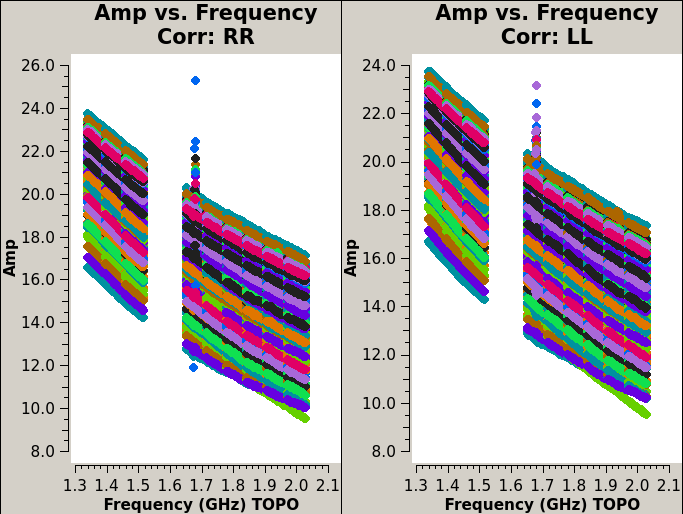

In [28]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

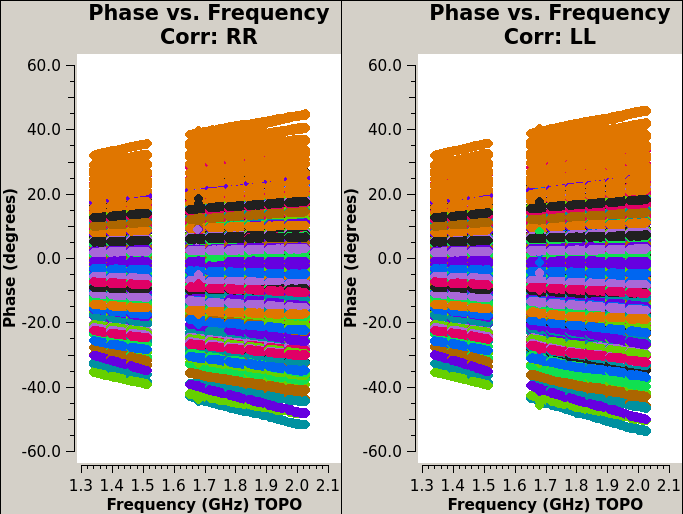

In [29]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

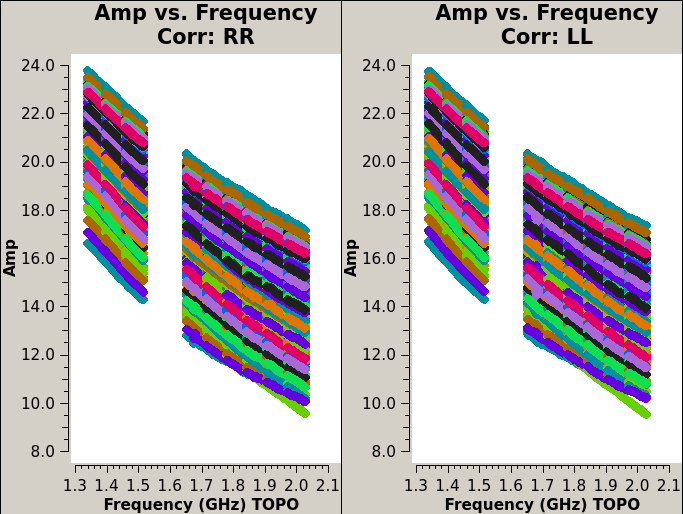

In [30]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

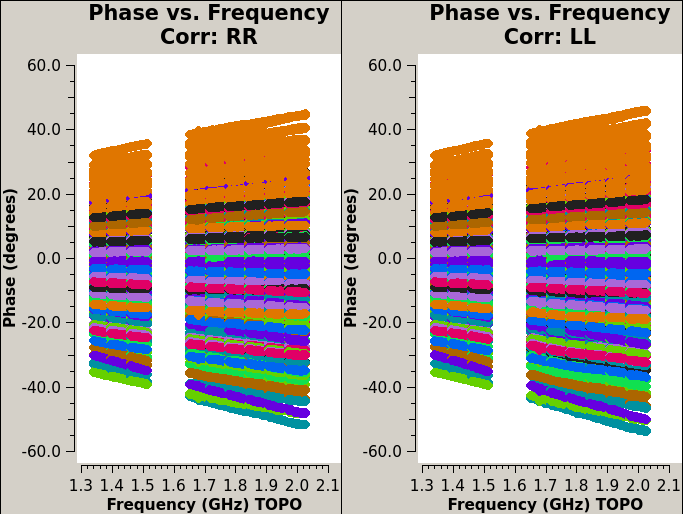

In [31]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Summary

In [32]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field J0542+4951
Before: 68.9800, After: 69.2338

antenna ea01
Before: 65.0810, After: 65.2951

antenna ea02
Before: 65.0810, After: 65.2600

antenna ea03
Before: 65.0810, After: 65.2064

antenna ea04
Before: 65.0810, After: 65.3719

antenna ea05
Before: 65.0810, After: 65.3532

antenna ea06
Before: 65.0810, After: 65.3304

antenna ea07
Before: 65.0810, After: 65.4040

antenna ea08
Before: 65.0810, After: 65.3525

antenna ea09
Before: 65.0810, After: 65.4872

antenna ea10
Before: 65.0810, After: 65.4672

antenna ea11
Before: 65.0810, After: 65.3810

antenna ea12
Before: 65.0810, After: 65.4502

antenna ea13
Before: 65.0810, After: 65.2380

antenna ea14
Before: 65.0810, After: 65.2805

antenna ea15
Before: 65.0810, After: 65.3893

antenna ea16
Before: 65.0810, After: 65.2910

antenna ea17
Before: 65.0810, After: 65.4449

antenna ea18
Before: 65.3390, After: 65.8465

antenna ea19
Before: 65.0810, After: 65.4318

ant

## Semi-Final Calibration
The steps from the intitial calibration are repeated. 

### Specify Gain Tables

In [33]:
# specify calibration table names
rnd = 1
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table_1 = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration

In [34]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

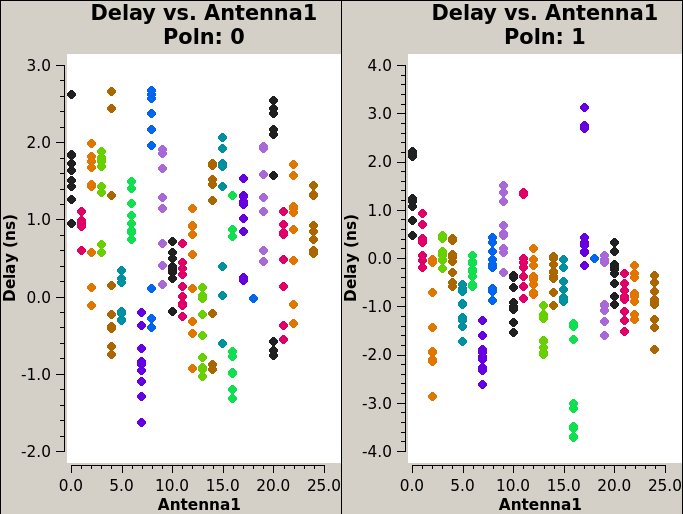

In [35]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [36]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table_1}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table_1}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [37]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [38]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

False

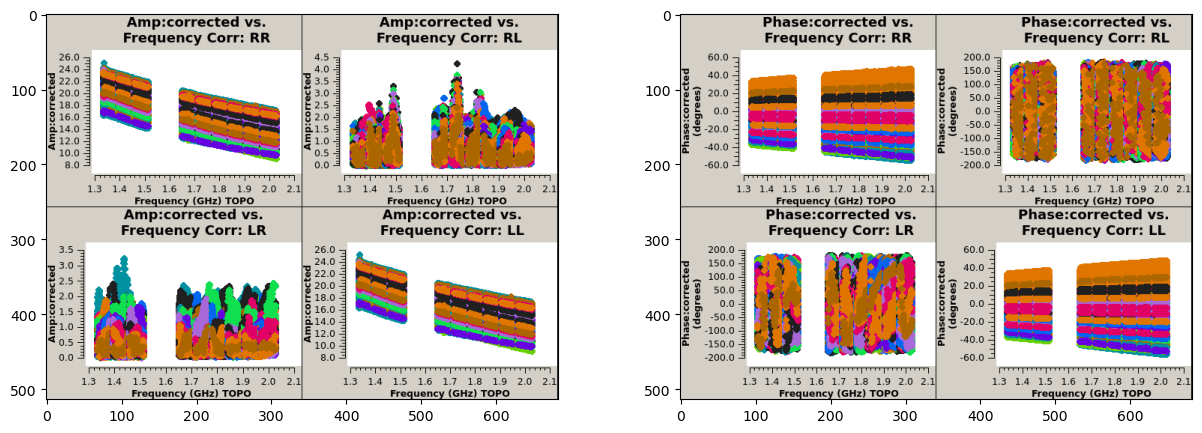

In [39]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_init_cal_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_init_cal_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

"fluxcal_init_cal_amp_vs_freq.png" in os.listdir(root + f"/plots/dataplots/")

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [40]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 1:

field J0542+4951
Before: 69.2338, After: 69.2359

antenna ea01
Before: 65.2951, After: 65.2978

antenna ea02
Before: 65.2600, After: 65.2600

antenna ea03
Before: 65.2064, After: 65.2149

antenna ea04
Before: 65.3719, After: 65.3719

antenna ea05
Before: 65.3532, After: 65.3541

antenna ea06
Before: 65.3304, After: 65.3304

antenna ea07
Before: 65.4040, After: 65.4049

antenna ea08
Before: 65.3525, After: 65.3525

antenna ea09
Before: 65.4872, After: 65.4918

antenna ea10
Before: 65.4672, After: 65.4713

antenna ea11
Before: 65.3810, After: 65.3810

antenna ea12
Before: 65.4502, After: 65.4539

antenna ea13
Before: 65.2380, After: 65.2420

antenna ea14
Before: 65.2805, After: 65.2805

antenna ea15
Before: 65.3893, After: 65.3893

antenna ea16
Before: 65.2910, After: 65.2910

antenna ea17
Before: 65.4449, After: 65.4449

antenna ea18
Before: 65.8465, After: 65.8490

antenna ea19
Before: 65.4318, After: 65.4361

ante

## Second Round of Flagging
The flagging is repeated, but this time on all calibrators.

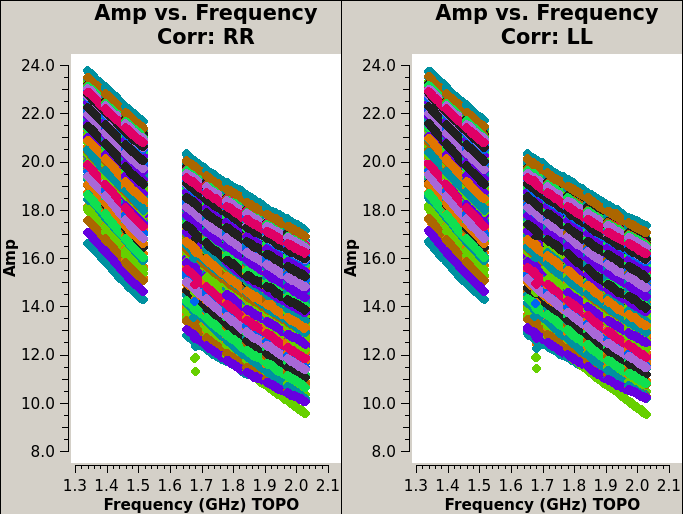

In [41]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

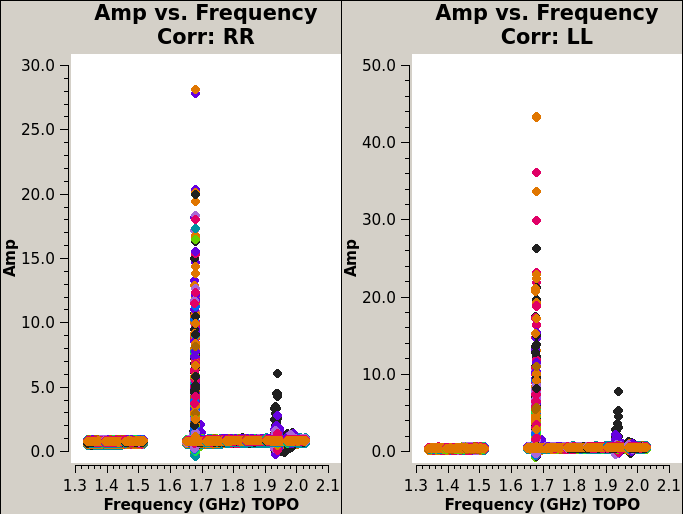

In [42]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

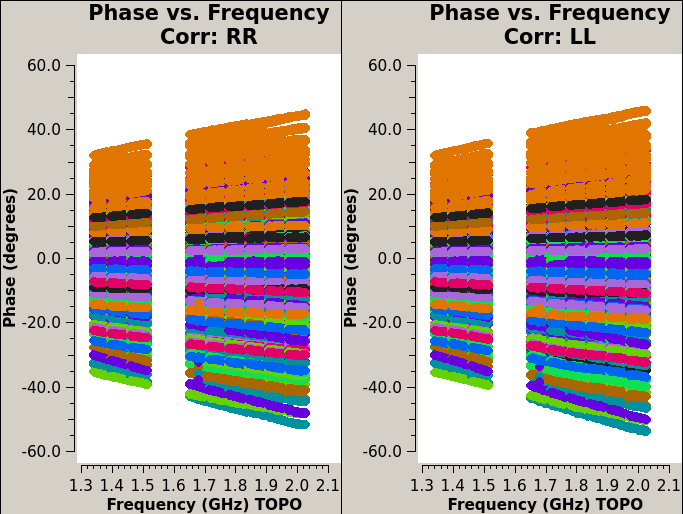

In [43]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

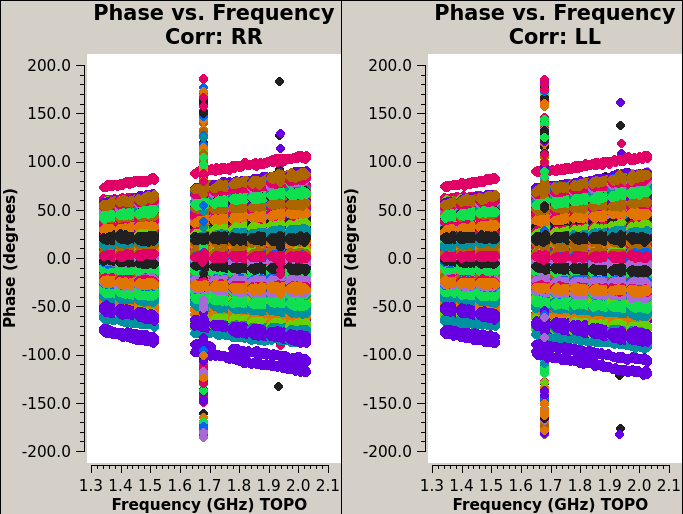

In [44]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

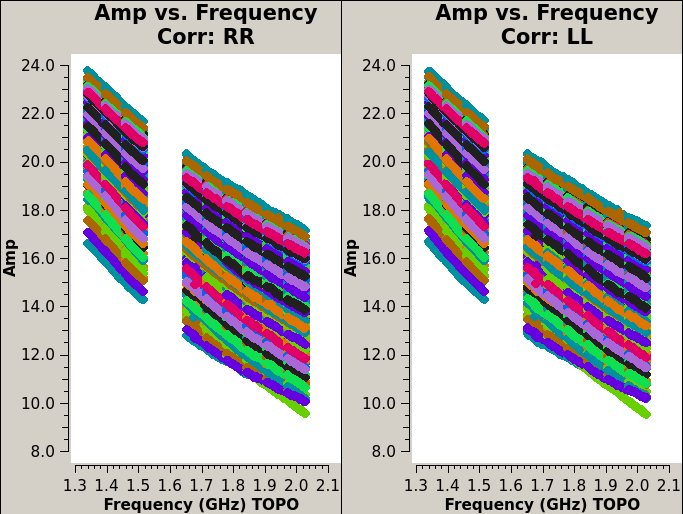

In [45]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

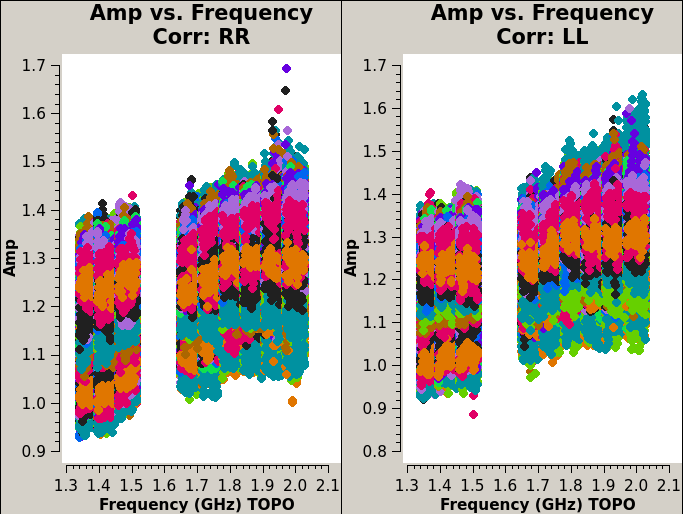

In [46]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

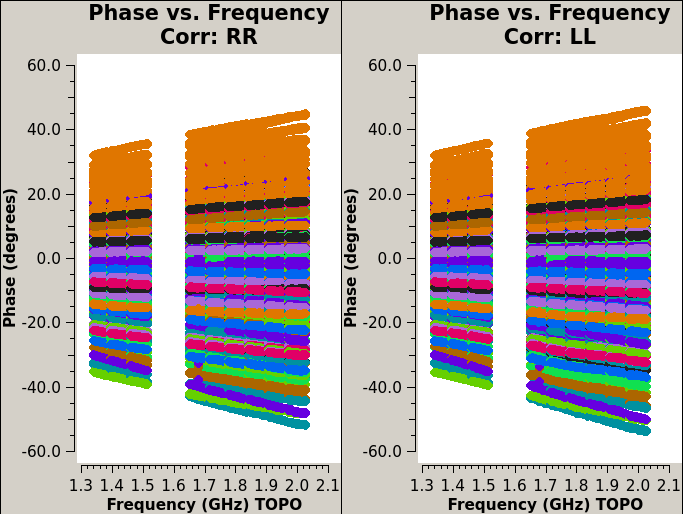

In [47]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

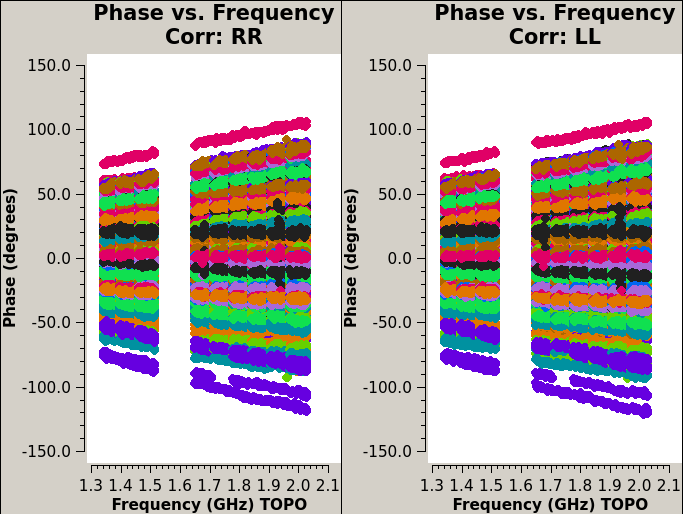

In [48]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Flagging Summary

In [49]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field J0542+4951
Before: 69.2359, After: 69.3554

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 65.6166, After: 65.7501

antenna ea01
Before: 65.2978, After: 65.3757

antenna ea02
Before: 65.2600, After: 65.3594

antenna ea03
Before: 65.2149, After: 65.3282

antenna ea04
Before: 65.3719, After: 65.5131

antenna ea05
Before: 65.3541, After: 65.4674

antenna ea06
Before: 65.3304, After: 65.4951

antenna ea07
Before: 65.4049, After: 65.5692

antenna ea08
Before: 65.3525, After: 65.4715

antenna ea09
Before: 65.4918, After: 65.6027

antenna ea10
Before: 65.4713, After: 65.6338

antenna ea11
Before: 65.3810, After: 65.4957

antenna ea12
Before: 65.4539, After: 65.6514

antenna ea13
Before: 65.2420, After: 65.3694

antenna ea14
Before: 65.2805, After: 65.3901

antenna ea15
Before: 65.3893, After: 65.5365

antenna ea16
Before: 65.2910, After: 65.4178

antenna ea17
Before: 65.4449, After: 65.6368

antenna ea18


In [50]:
summary_before = np.load(root + f"/output/phasecal_round_0_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_round_0_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the phase calibrators:

field J1033+4116
Before: 78.3158, After: 78.6627

field J1130+3815
Before: 69.9944, After: 70.5629

scan 3
Before: 85.7316, After: 85.9709

scan 5
Before: 65.3113, After: 65.8468

scan 6
Before: 73.8413, After: 74.3570

scan 8
Before: 65.6667, After: 66.2945

antenna ea01
Before: 71.7013, After: 72.6035

antenna ea02
Before: 71.6675, After: 72.2550

antenna ea03
Before: 71.6675, After: 72.1401

antenna ea04
Before: 71.6675, After: 71.8753

antenna ea05
Before: 71.7013, After: 72.1252

antenna ea06
Before: 71.6675, After: 71.9816

antenna ea07
Before: 71.7013, After: 72.2179

antenna ea08
Before: 71.6675, After: 72.5433

antenna ea09
Before: 71.7013, After: 72.1368

antenna ea10
Before: 71.7013, After: 72.4981

antenna ea11
Before: 71.6675, After: 71.9194

antenna ea12
Before: 71.7013, After: 72.4620

antenna ea13
Before: 71.6675, After: 72.2372

antenna ea14
Before: 71.6675, After: 72.0966

antenna ea15
Before: 

In [51]:
summary_before = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:

field J1033+4116
Before: 79.2382, After: 79.3304

field J1130+3815
Before: 71.2671, After: 71.4033

scan 3
Before: 86.3389, After: 86.4030

scan 5
Before: 66.7862, After: 66.9278

scan 6
Before: 74.9544, After: 75.0848

scan 8
Before: 67.1188, After: 67.2616

antenna ea01
Before: 73.1528, After: 73.2748

antenna ea02
Before: 72.8933, After: 73.0235

antenna ea03
Before: 72.8309, After: 72.9271

antenna ea04
Before: 72.7159, After: 72.8243

antenna ea05
Before: 72.8722, After: 72.9892

antenna ea06
Before: 72.7209, After: 72.9435

antenna ea07
Before: 72.9177, After: 73.0221

antenna ea08
Before: 73.1645, After: 73.3156

antenna ea09
Before: 72.8189, After: 72.9330

antenna ea10
Before: 73.1037, After: 73.2341

antenna ea11
Before: 72.7245, After: 72.8306

antenna ea12
Before: 73.0261, After: 73.1775

antenna ea13
Before: 72.8268, After: 73.0090

antenna ea14
Before: 72.8282, After: 73.0367

antenna

## Final Calibration
First, the initial calibration (delay and bandpass) are repeated on the primary calibrator. Then, the final gains of the calibrators are derived.

### Specify Gain Tables

In [52]:
# specify calibration table names
rnd = 2
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

fluxcal_phase_table = f"{name}_fluxcal_phase.Gfinal"
short_gain_table = f"{name}_short.Gfinal"
amp_gain_table = f"{name}_amp.Gfinal"
phase_gain_table = f"{name}_phase.Gfinal"

### Delay Initial Gain Calibration

In [53]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

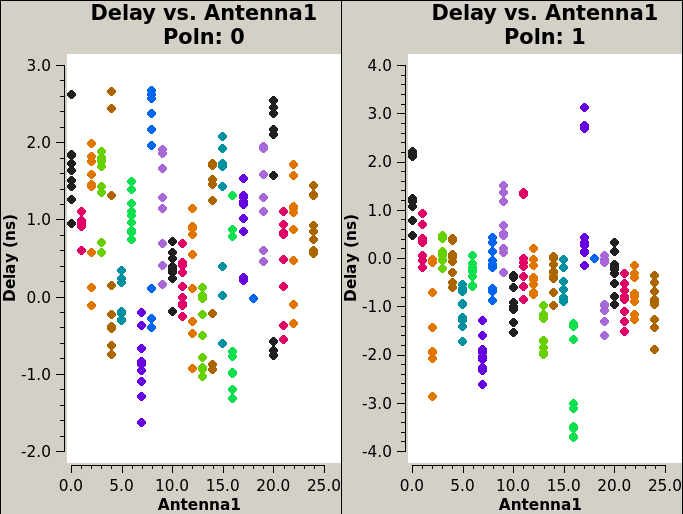

In [54]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [55]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [56]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [57]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Flux Calibrator Final Gain Phase

In [58]:
def plot_final_fluxcal_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{fluxcal_phase_table}_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_fluxcal_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_fluxcal_phase(ant)>

### Short Interval Gain Calibration
This is an initial calibration done on a per-integration basis on the calibrators.

In [59]:
def plot_final_short_gain_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{short_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_short_gain_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_short_gain_phase(ant)>

### Long Interval Gain Calibration
The gain amplitudes of the calibrators of solved for using the initial gain phase calibration above.

In [60]:
def plot_final_long_gain(ant):
    plot_two_cols(
        root + f'/plots/calplots/{amp_gain_table}_amp_ant_{ant}_Poln0,1.png',
        root + f'/plots/calplots/{amp_gain_table}_phase_ant_{ant}_Poln0,1.png'
    )

interact(plot_final_long_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_long_gain(ant)>

### Phase Calibration
Derive the final gain phases of the calibrators. That of the primary calibrator should be close to zero, since it was already derived and applied earlier on.

In [61]:
def plot_final_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{phase_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_phase(ant)>

### Flagging Summary

In [62]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after final delay and bandpass calibration:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after final delay and bandpass calibration:

field J0542+4951
Before: 69.2338, After: 69.2359

antenna ea01
Before: 65.2951, After: 65.2978

antenna ea02
Before: 65.2600, After: 65.2600

antenna ea03
Before: 65.2064, After: 65.2149

antenna ea04
Before: 65.3719, After: 65.3719

antenna ea05
Before: 65.3532, After: 65.3541

antenna ea06
Before: 65.3304, After: 65.3304

antenna ea07
Before: 65.4040, After: 65.4049

antenna ea08
Before: 65.3525, After: 65.3525

antenna ea09
Before: 65.4872, After: 65.4918

antenna ea10
Before: 65.4672, After: 65.4713

antenna ea11
Before: 65.3810, After: 65.3810

antenna ea12
Before: 65.4502, After: 65.4539

antenna ea13
Before: 65.2380, After: 65.2420

antenna ea14
Before: 65.2805, After: 65.2805

antenna ea15
Before: 65.3893, After: 65.3893

antenna ea16
Before: 65.2910, After: 65.2910

antenna ea17
Before: 65.4449, After: 65.4449

antenna ea18
Before: 65.8465, After: 65.8490

antenna ea19
Before: 65.4318, After: 65.4

In [63]:
summary_before = np.load(root + f"/output/applycal_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/applycal_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after applying final calibration:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after applying final calibration:

field J0542+4951
Before: 69.3568, After: 69.3568

field J1033+4116
Before: 78.6628, After: 78.6628

field J1130+3815
Before: 70.5631, After: 70.5631

field QSO J1048+4637
Before: 63.6731, After: 63.6731

field QSO J1137+3549
Before: 62.2459, After: 62.2459

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 65.7518, After: 65.7518

scan 3
Before: 85.9709, After: 85.9709

scan 4
Before: 63.6731, After: 63.6731

scan 5
Before: 65.8472, After: 65.8472

scan 6
Before: 74.3572, After: 74.3572

scan 7
Before: 62.2459, After: 62.2459

scan 8
Before: 66.2947, After: 66.2947

antenna ea01
Before: 64.3037, After: 64.3037

antenna ea02
Before: 64.1954, After: 64.1954

antenna ea03
Before: 64.1426, After: 64.1426

antenna ea04
Before: 64.1210, After: 64.1210

antenna ea05
Before: 64.2429, After: 64.2429

antenna ea06
Before: 64.1360, After: 64.1360

antenna ea07
Before: 64.2963, After: 64.2963

antenna ea08
Before: 64.309

## Target Flags
Now that the final calibration tables have been derived and applied to the data, the automated flagging routine is run on the target fields.

### Before Flagging

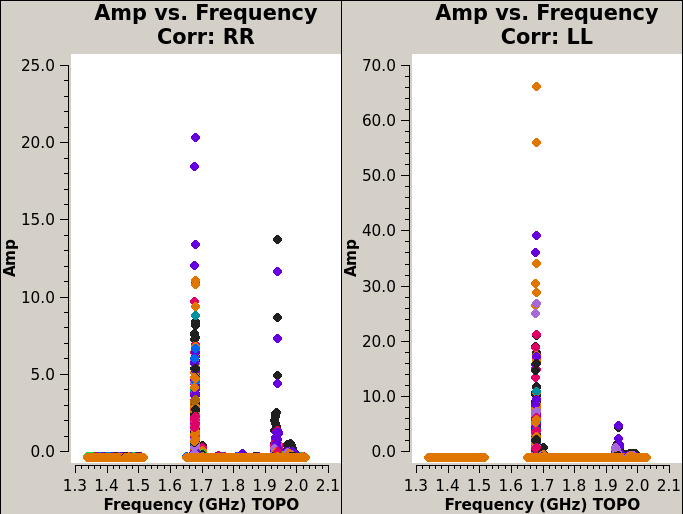

In [64]:
Image(filename=root + "/plots/dataplots/before_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### After Flagging

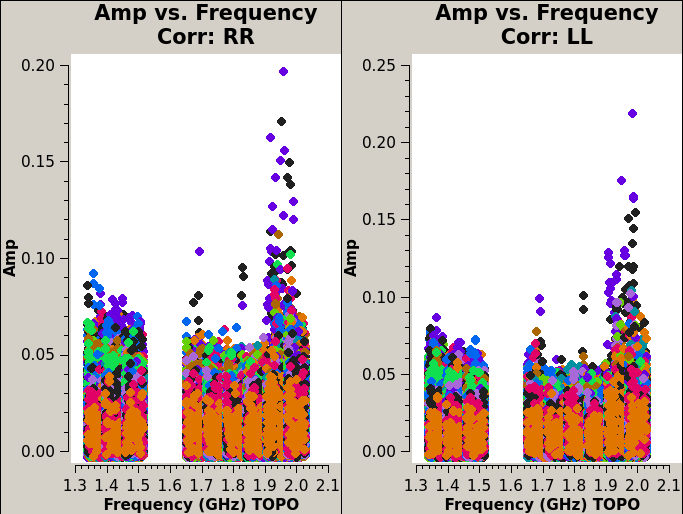

In [65]:
Image(filename=root + "/plots/dataplots/after_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### Summary

In [66]:
rnd=0
summary_before = np.load(root + f"/output/targets_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/targets_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) after flagging the flux calibrator:

field QSO J1048+4637
Before: 63.6731, After: 64.2360

field QSO J1137+3549
Before: 62.2459, After: 63.0789

scan 4
Before: 63.6731, After: 64.2360

scan 7
Before: 62.2459, After: 63.0789

antenna ea01
Before: 58.2858, After: 60.0784

antenna ea02
Before: 58.2858, After: 59.5857

antenna ea03
Before: 58.2609, After: 59.1205

antenna ea04
Before: 58.2858, After: 58.5063

antenna ea05
Before: 58.4172, After: 58.7875

antenna ea06
Before: 58.2609, After: 58.6086

antenna ea07
Before: 58.4172, After: 58.9661

antenna ea08
Before: 58.2858, After: 59.9754

antenna ea09
Before: 58.2858, After: 58.9879

antenna ea10
Before: 58.2858, After: 59.7058

antenna ea11
Before: 58.2609, After: 58.5824

antenna ea12
Before: 58.2858, After: 59.5448

antenna ea13
Before: 58.2609, After: 59.2273

antenna ea14
Before: 58.3497, After: 58.8468

antenna ea15
Before: 58.2858, After: 58.5850

antenna ea16
Before: 58.4172, After: 58.6569

antenna ea17
B

## Summary Plots
These plots show the corrected amplitudes and phases of all fields as a function of uv-distance and frequency. The values plotted against uv-distance are colorised by spectral window while those plotted against frequency are colorised by antenna number. Remaining RFI should be flagged manually in CASA.

In [67]:
field_dict = vladata.get_field_names(ms)
fields = field_dict["calibrators"] + "," + field_dict["targets"]

J0542+4951


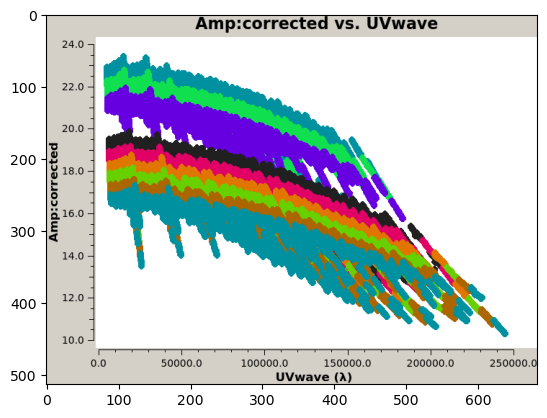

J1033+4116


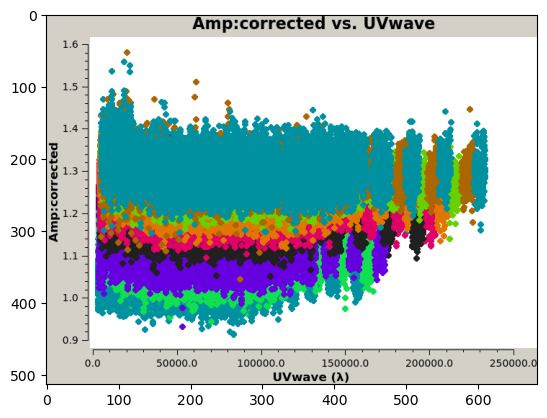

J1130+3815


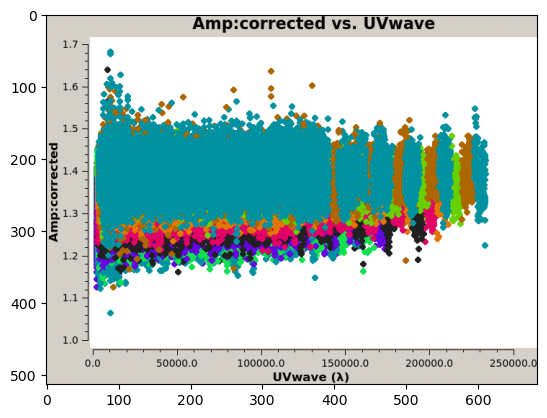

QSO J1048+4637


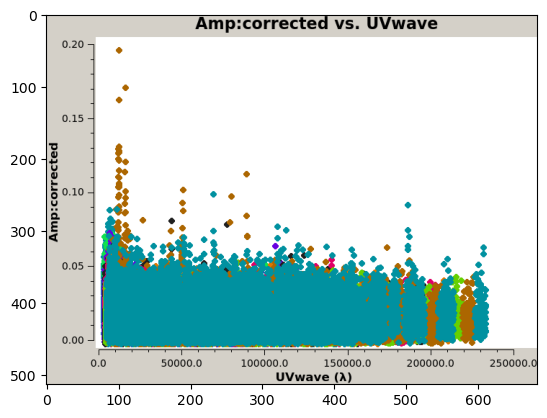

QSO J1137+3549


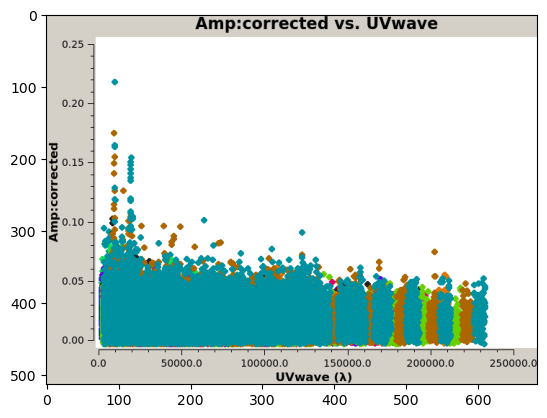

In [68]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_uvdist_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

J0542+4951


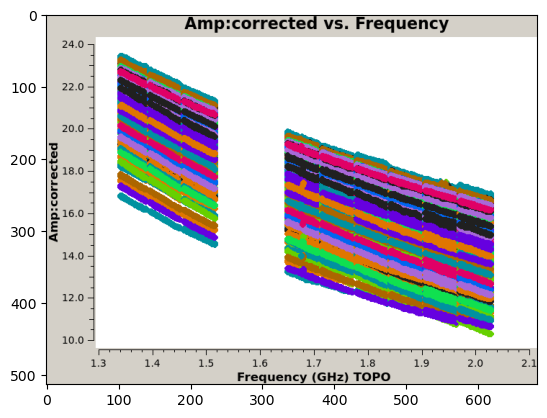

J1033+4116


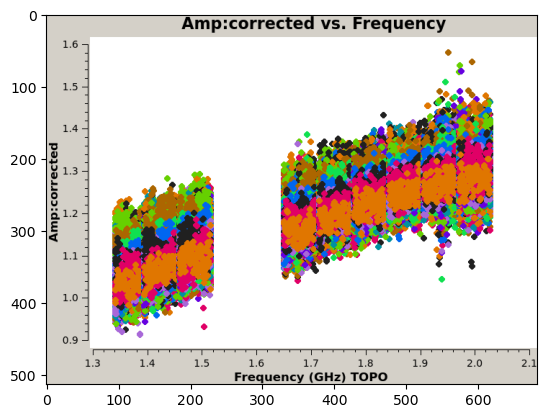

J1130+3815


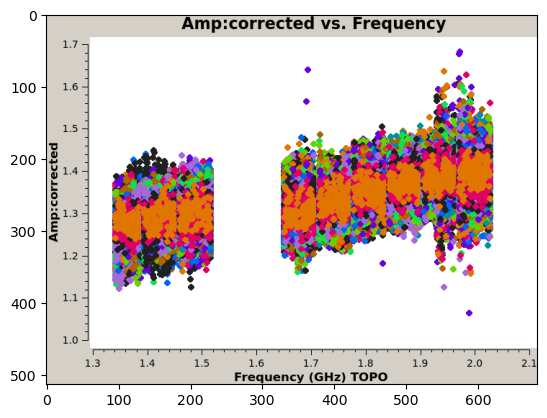

QSO J1048+4637


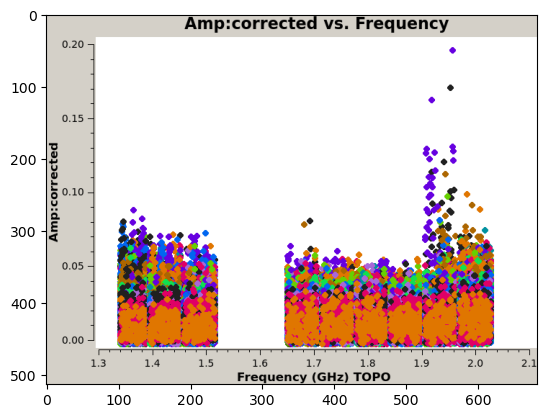

QSO J1137+3549


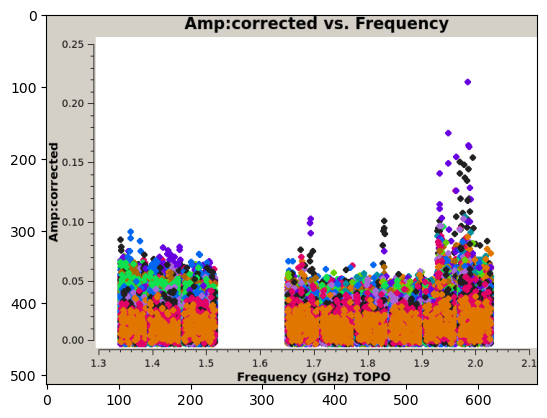

In [69]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

J0542+4951


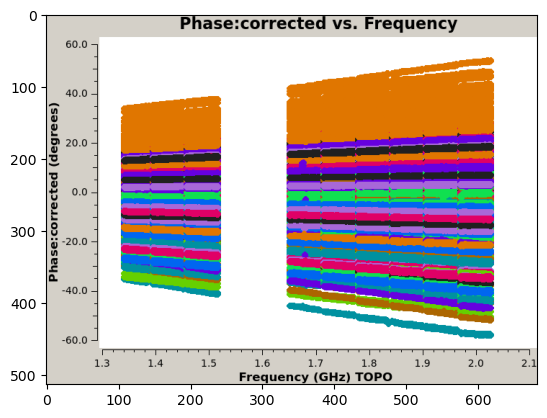

J1033+4116


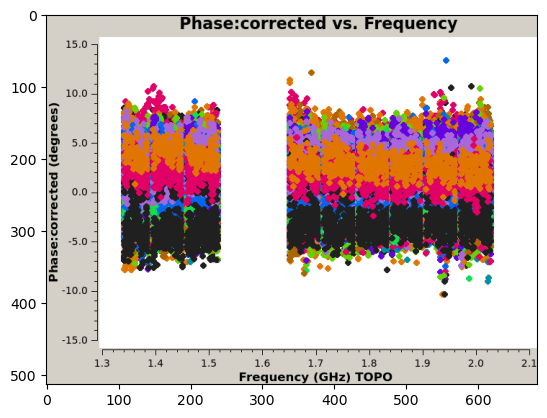

J1130+3815


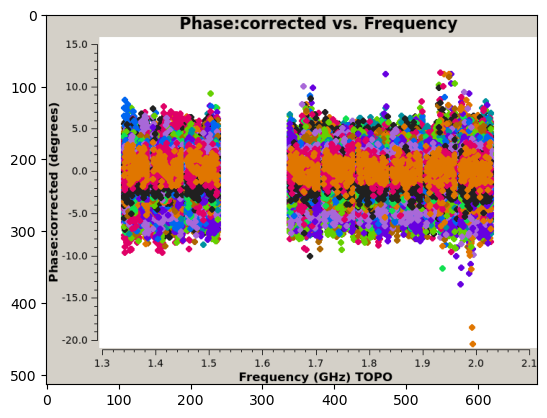

QSO J1048+4637


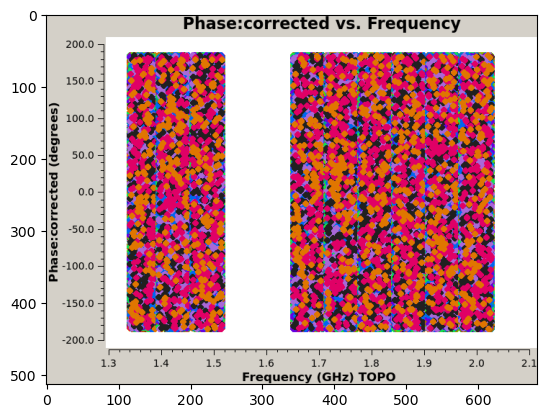

QSO J1137+3549


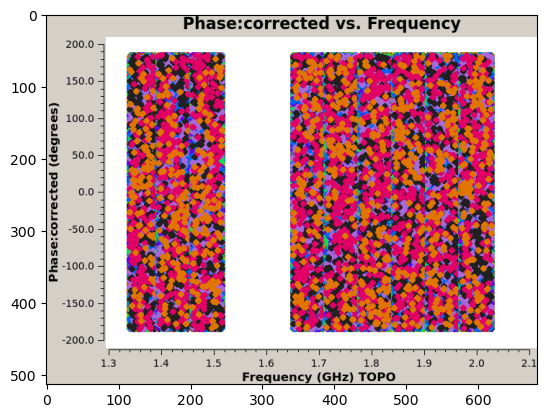

In [70]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_phase_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

In [71]:

with h5py.File(root + f"/output/z_score_corrected.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

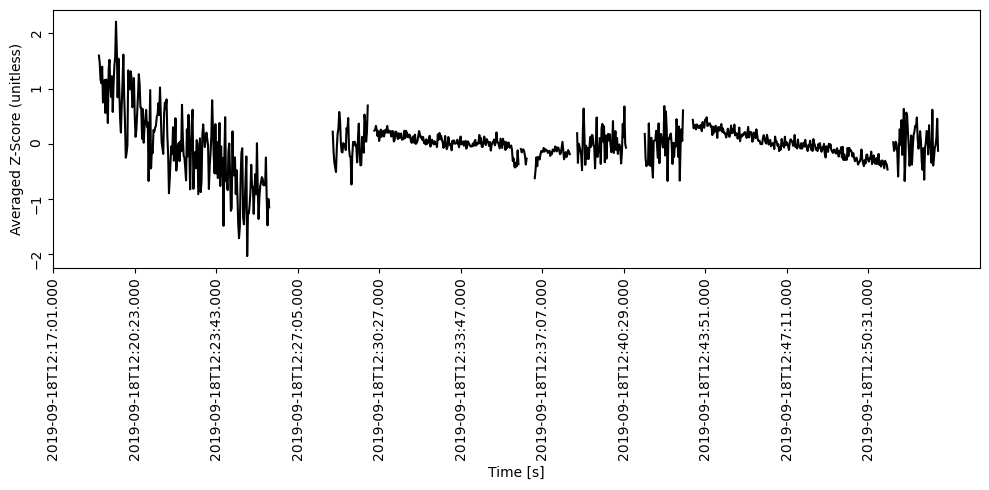

In [72]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
ax = inspect.plot_time_series(tisot, np.ma.median(z_score, axis=1), ax, plot_masked=True)
ax.set_ylabel("Averaged Z-Score (unitless)")
ax.set_xticks(tisot[::100])
plt.tight_layout()

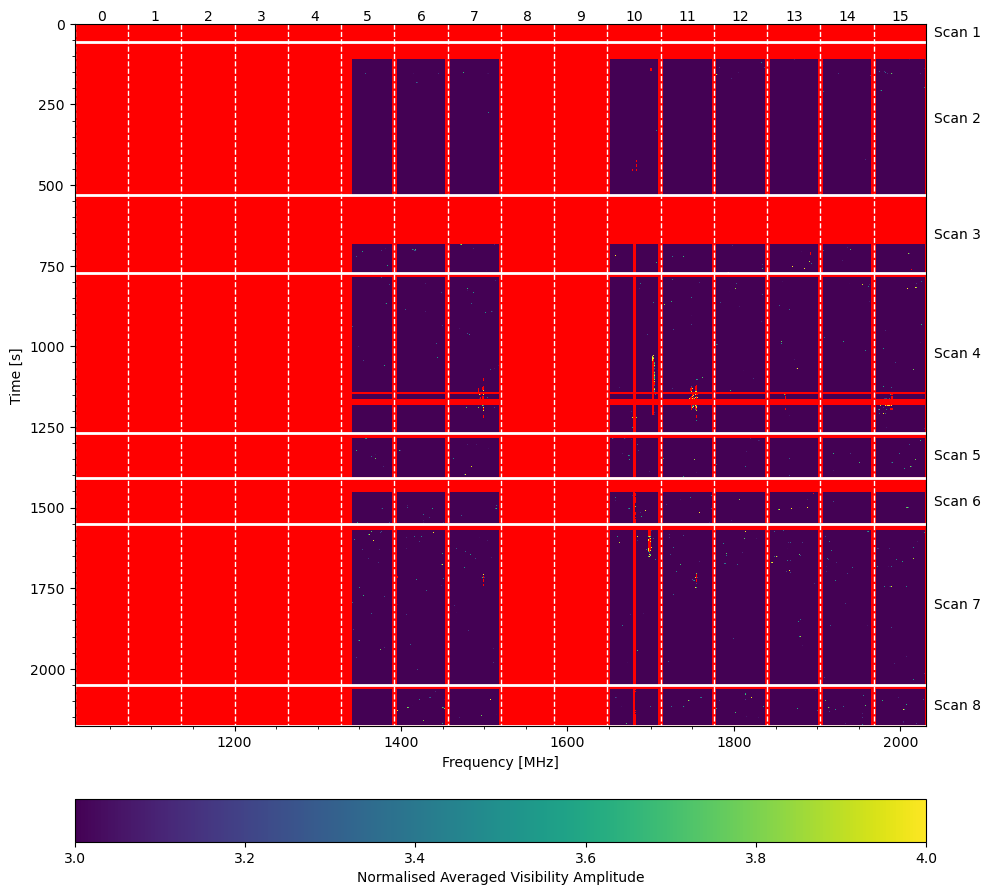

In [73]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=3, vmax=4, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", pad=0.08, label="Normalised Averaged Visibility Amplitude")